In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import os
import keras

from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, decode_predictions
from keras.layers import Dense, Flatten, Embedding, Input, Dropout, Concatenate
from keras.models import Model
from keras.optimizers import Nadam
from keras import backend as K

Using TensorFlow backend.


## Loading data into dataframes

In [2]:
data_folder = os.path.join(os.path.abspath(os.curdir), os.pardir, "data")

In [3]:
training_data = os.path.join(data_folder, "processed", "train_train.csv")
train_df = pd.read_csv(training_data)
train_df = train_df.assign(image_path = train_df.image + ".jpg")
subsampled_train_df = train_df.sample(frac=0.01, replace=False, random_state=0)

In [4]:
validation_data = os.path.join(data_folder, "processed", "train_validation.csv")
validation_df = pd.read_csv(validation_data)
validation_df = validation_df.assign(image_path = validation_df.image + ".jpg")
subsampled_validation_df = validation_df.sample(frac=0.01, replace=False, random_state=0)

In [5]:
city_index_mapping = {city : int(index + 1) for index, city in enumerate(np.unique(subsampled_train_df.city.values))}
category_index_mapping = {category : int(index + 1) for index, category in enumerate(np.unique(subsampled_train_df.category_name.values))}
region_index_mapping = {region : int(index + 1) for index, region in enumerate(np.unique(subsampled_train_df.region.values))}
parent_category_index_mapping = {par_category : int(index + 1) for index, par_category in enumerate(np.unique(subsampled_train_df.parent_category_name.values))}

In [6]:
subsampled_train_df = subsampled_train_df.assign(city_index = subsampled_train_df.city.map(city_index_mapping),
                                                category_index = subsampled_train_df.category_name.map(category_index_mapping),
                                                region_index = subsampled_train_df.region.map(region_index_mapping),
                                                parent_category_index = subsampled_train_df.parent_category_name.map(parent_category_index_mapping))
subsampled_validation_df = subsampled_validation_df.assign(city_index = subsampled_validation_df.city.map(city_index_mapping),
                                                category_index = subsampled_validation_df.category_name.map(category_index_mapping),
                                                region_index = subsampled_validation_df.region.map(region_index_mapping),
                                                parent_category_index = subsampled_validation_df.parent_category_name.map(parent_category_index_mapping))

In [7]:
required_features = ["deal_probability", "image_path", "category_index",\
                     "city_index", "region_index", "parent_category_index", "price"]

In [8]:
subsampled_validation_df = subsampled_validation_df[required_features].dropna()
subsampled_train_df = subsampled_train_df[required_features].dropna()

In [9]:
subsampled_train_df.head()

,deal_probability,image_path,category_index,city_index,region_index,parent_category_index,price
223617,0.00000,bfe0f269734a36022d8f9ed3080c52508ceda3948f7623...,1,549,24,7,315000.0
506290,0.00000,14de02f13446f40796af7c9be5dd54afc0b9758af2761a...,26,81,7,1,18500.0
611342,0.00000,08d733bb2c05103d1d45b874455fe5cf55fb3ae6db26c7...,11,580,27,5,50.0
358153,0.21651,c04d6059a66c4b786e933f78dec4caf41023fd88dcb821...,3,168,10,1,1600.0
874693,0.00000,380eac54ee5214e07fcbdffd9517e0369050c0ea782b29...,30,263,10,5,14000.0


In [10]:
image_folder = os.path.join(data_folder, "raw", "train_jpg", "data", "competition_files", "train_jpg")

In [11]:
subsampled_train_image_df = subsampled_train_df[['image_path', "deal_probability"]]

In [12]:
subsampled_validation_image_df = subsampled_validation_df[['image_path', "deal_probability"]]

In [13]:
subsampled_train_image_df.shape

(10611, 2)

In [14]:
subsampled_validation_image_df.shape

(2663, 2)

In [15]:
invalid = []
for path in subsampled_train_image_df.image_path.values:
    try:
        img = Image.open(os.path.join(image_folder, path))
        img.close()
    except:
        subsampled_train_df = subsampled_train_df[subsampled_train_image_df['image_path'] != path]
        subsampled_train_image_df = subsampled_train_image_df[subsampled_train_image_df['image_path'] != path]
        invalid.append(path)

In [16]:
invalid

['c34772fc6d4e6d75171b75595243cb083cc3ea18b7b5ea0a62c0137e3029ace0.jpg',
 'cec3df785ac19d20f8a7d0ccc8462e6f9d813c1d43ccba3fcf982b338325e468.jpg',
 '78e99f9069c351705357c1fc02e3c532e791d0c8b54796857650d59ef3d52349.jpg']

## Enable loading images from disk

In [17]:
image_generator = ImageDataGenerator()

In [18]:
train_image_generator = image_generator.flow_from_dataframe(dataframe=subsampled_train_image_df, directory=image_folder, x_col="image_path", y_col="deal_probability",
                                                           class_mode='other', target_size=(224, 224), color_mode='rgb', batch_size=48)

Found 10608 images.


In [19]:
validation_image_generator = image_generator.flow_from_dataframe(dataframe=subsampled_validation_image_df, directory=image_folder, x_col="image_path", y_col="deal_probability",
                                                           class_mode='other', target_size=(224, 224), color_mode='rgb', batch_size=48)

Found 2663 images.


## Crafting training data

In [20]:
subsampled_train_df.head()

,deal_probability,image_path,category_index,city_index,region_index,parent_category_index,price
223617,0.00000,bfe0f269734a36022d8f9ed3080c52508ceda3948f7623...,1,549,24,7,315000.0
506290,0.00000,14de02f13446f40796af7c9be5dd54afc0b9758af2761a...,26,81,7,1,18500.0
611342,0.00000,08d733bb2c05103d1d45b874455fe5cf55fb3ae6db26c7...,11,580,27,5,50.0
358153,0.21651,c04d6059a66c4b786e933f78dec4caf41023fd88dcb821...,3,168,10,1,1600.0
874693,0.00000,380eac54ee5214e07fcbdffd9517e0369050c0ea782b29...,30,263,10,5,14000.0


In [21]:
len(subsampled_train_df.region_index.unique()) + len(subsampled_train_df.city_index.unique()) +\
len(subsampled_train_df.category_index.unique()) + len(subsampled_train_df.parent_category_index.unique())

633

In [22]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

In [23]:
train_cat_X = subsampled_train_df[["city_index", "category_index", "region_index", "parent_category_index"]].values
val_cat_X = subsampled_validation_df[["city_index", "category_index", "region_index", "parent_category_index"]].values
enc = OneHotEncoder(categories="auto", handle_unknown="ignore")
onehot_train_X = enc.fit_transform(train_cat_X)
onehot_val_X = enc.transform(val_cat_X)

In [24]:
print(np.sum(onehot_train_X)/4, train_cat_X.shape[0])

10608.0 10608


In [25]:
onehot_train_X.shape

(10608, 633)

In [26]:
train_X = np.concatenate((onehot_train_X.toarray(), subsampled_train_df.price.values.reshape(-1, 1)), axis=1)
val_X = np.concatenate((onehot_val_X.toarray(), subsampled_validation_df.price.values.reshape(-1, 1)), axis=1)

In [27]:
train_y = subsampled_train_df.deal_probability.values
val_y = subsampled_validation_df.deal_probability.values

## Simple neural network

In [218]:
input_ = Input(shape=(train_X.shape[1],))

In [219]:
a = Dense(1024, activation="relu")(input_)

In [220]:
b = Dense(512, activation="relu")(a)
dropout = Dropout(0.5)(b)
c = Dense(128, activation="relu")(dropout)
d = Dense(64, activation="relu")(c)

In [221]:
output = Dense(1, activation="sigmoid")(a)

In [222]:
dense_model = Model(inputs=input_, outputs=output)

In [223]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [224]:
dense_model.compile(optimizer="Adam", loss="mean_squared_error", metrics=["mean_squared_error"])

In [225]:
dense_model.fit(x=train_X, y=subsampled_train_df.deal_probability.values, epochs=10,
               batch_size=512, validation_data=(val_X, subsampled_validation_df.deal_probability.values))

Train on 217554 samples, validate on 54487 samples
Epoch 1/10
217554/217554 [==============================] - 6s 26us/step - loss: 0.0548 - mean_squared_error: 0.0548 - val_loss: 0.0533 - val_mean_squared_error: 0.0533
Epoch 2/10
217554/217554 [==============================] - 5s 23us/step - loss: 0.0538 - mean_squared_error: 0.0538 - val_loss: 0.0533 - val_mean_squared_error: 0.0533
Epoch 3/10
217554/217554 [==============================] - 5s 23us/step - loss: 0.0530 - mean_squared_error: 0.0530 - val_loss: 0.0533 - val_mean_squared_error: 0.0533
Epoch 4/10
217554/217554 [==============================] - 5s 24us/step - loss: 0.0530 - mean_squared_error: 0.0530 - val_loss: 0.0533 - val_mean_squared_error: 0.0533
Epoch 5/10
217554/217554 [==============================] - 5s 24us/step - loss: 0.0530 - mean_squared_error: 0.0530 - val_loss: 0.0533 - val_mean_squared_error: 0.0533
Epoch 6/10
217554/217554 [==============================] - 5s 23us/step - loss: 0.0530 - mean_squared_e

KeyboardInterrupt: 

In [12]:
train_mean = np.mean(subsampled_train_df.deal_probability.values)
val_y = subsampled_validation_df.deal_probability.values[:10000]
mse = np.mean(np.power(val_y - train_mean, 2))
rmse = np.sqrt(mse)
print(mse, rmse)

0.04568878448005054 0.2137493496599476


In [71]:
val_X.shape

(54487, 1297)

In [72]:
y_pred = dense_model.predict(val_X[:10000, :])

In [64]:
sns.set(rc={'figure.figsize':(20,15)})

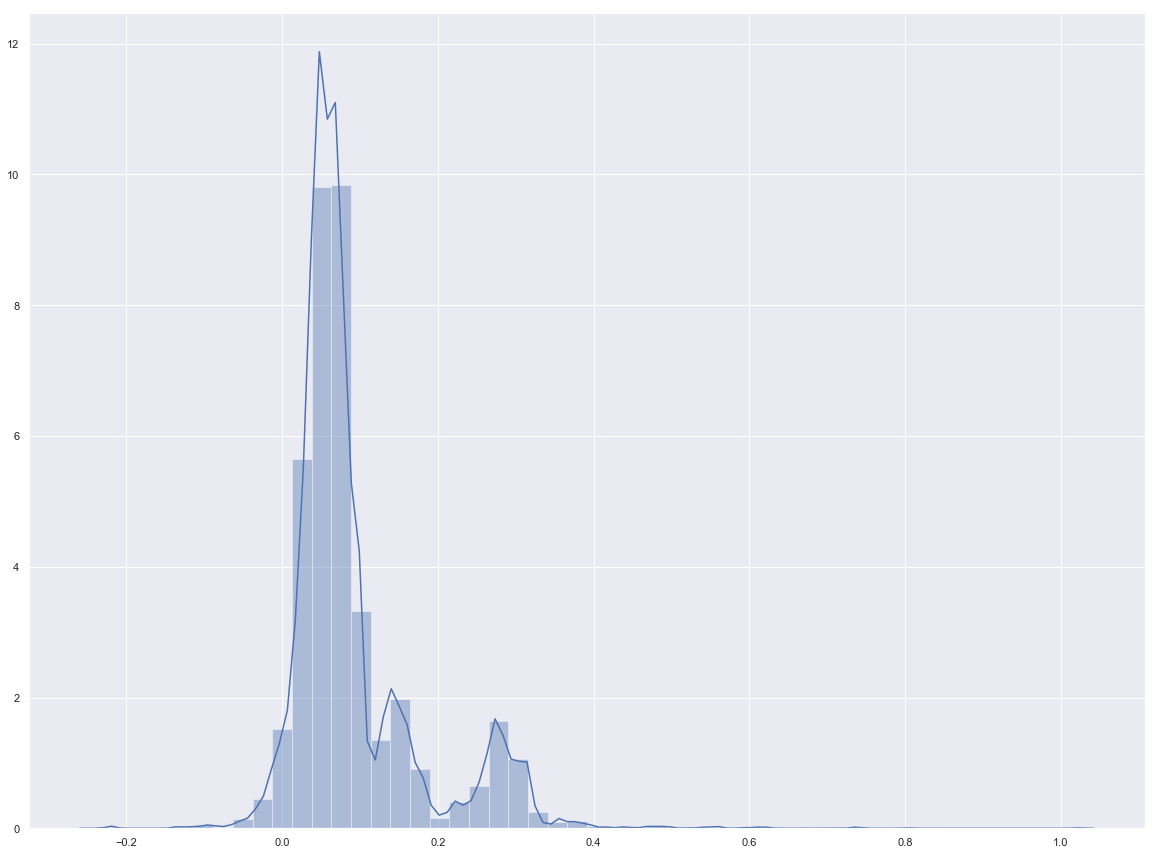

In [65]:
sns.distplot(y_pred, bins=50)

In [32]:
mse = np.mean(np.power(val_y - y_pred, 2))
rmse = np.sqrt(mse)
print(mse, rmse)

0.04575248736173896 0.2138983107968339


## Lasso

In [13]:
from sklearn.linear_model import Lasso

In [40]:
from sklearn.model_selection import GridSearchCV

In [47]:
train_X_lm = train_X[:10000, :]
train_y_lm = subsampled_train_df.deal_probability.values[:10000]

In [70]:
estimator = Lasso()
param_grid = {"alpha" : np.arange(0.001, 0.02, 0.001)}

In [71]:
param_grid

{'alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
        0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
        0.019])}

In [100]:
cv = GridSearchCV(estimator, param_grid, cv=10)

In [101]:
cv.fit(train_X_lm, train_y_lm)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [102]:
cv.best_params_

{'alpha': 0.006}

In [77]:
best_lasso = cv.best_estimator_

In [89]:
y_pred = best_lasso.predict(val_X[:10000, :])

In [90]:
val_y = subsampled_validation_df.deal_probability.values[:10000]
mse = np.mean(np.power(val_y - y_pred, 2))
rmse = np.sqrt(mse)
print("MSE: {0} | RMSE: {1}".format(mse, rmse))

MSE: 0.03999484930821657 | RMSE: 0.19998712285598932


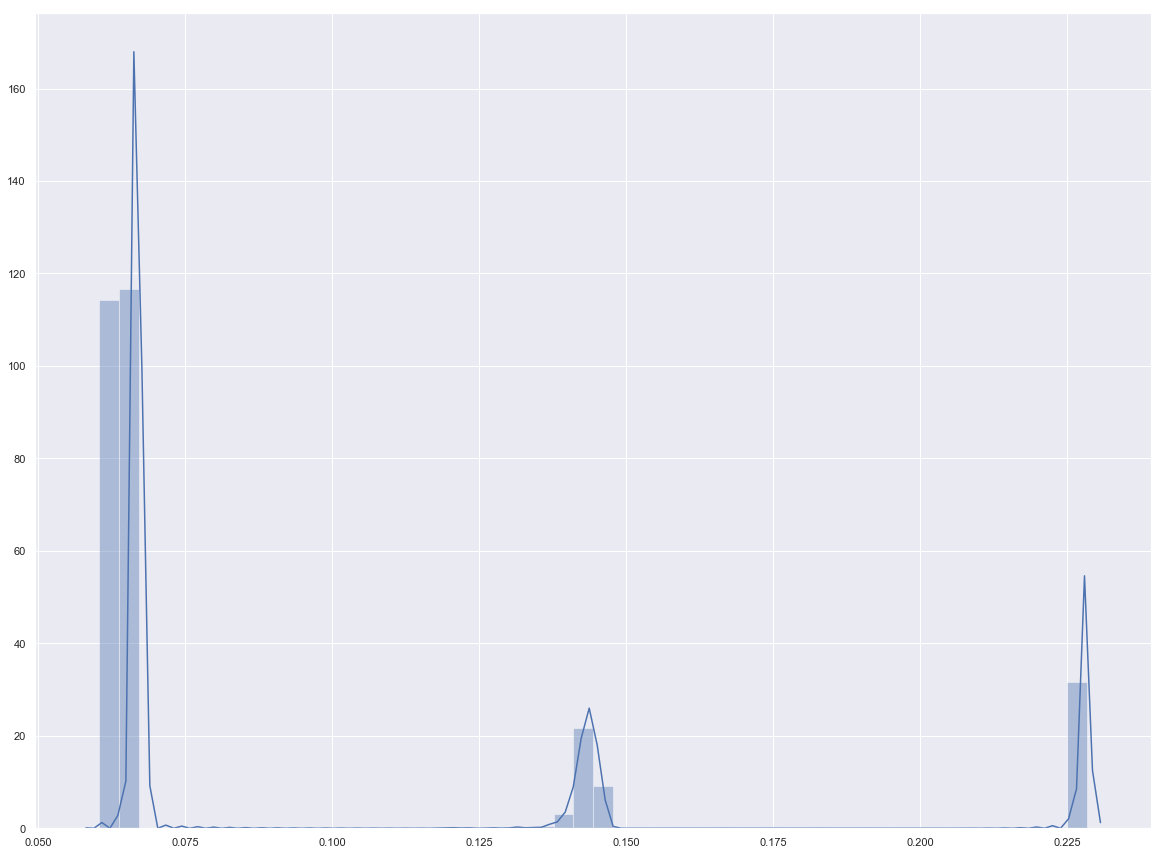

In [91]:
sns.distplot(y_pred, bins=50)

In [96]:
np.sum(best_lasso.coef_ != 0)

4

In [161]:
np.where(best_lasso.coef_ != 0)[0]

array([1258, 1264, 1293, 1296], dtype=int64)

In [132]:
np.concatenate(enc.categories_)[1293]

5

In [172]:
nonzeros = []
for index in np.where(best_lasso.coef_ != 0)[0][:3]:
    encoded = np.zeros((train_X.shape[1], ))
    encoded[index] = 1
    decoded = enc.inverse_transform(encoded[:1296].reshape((-1,1296)))
    nonzeros.append(decoded)

In [173]:
nonzeros
#Cars, clothes and personal things

[array([[None, 1, None, None]], dtype=object),
 array([[None, 30, None, None]], dtype=object),
 array([[None, None, None, 5]], dtype=object)]

In [149]:
category_index_mapping

({'Автомобили': 1,
  'Аквариум': 2,
  'Аудио и видео': 3,
  'Билеты и путешествия': 4,
  'Бытовая техника': 5,
  'Велосипеды': 6,
  'Водный транспорт': 7,
  'Гаражи и машиноместа': 8,
  'Готовый бизнес': 9,
  'Грузовики и спецтехника': 10,
  'Детская одежда и обувь': 11,
  'Дома, дачи, коттеджи': 12,
  'Другие животные': 13,
  'Земельные участки': 14,
  'Игры, приставки и программы': 15,
  'Квартиры': 16,
  'Книги и журналы': 17,
  'Коллекционирование': 18,
  'Коммерческая недвижимость': 19,
  'Комнаты': 20,
  'Кошки': 21,
  'Красота и здоровье': 22,
  'Мебель и интерьер': 23,
  'Мотоциклы и мототехника': 24,
  'Музыкальные инструменты': 25,
  'Настольные компьютеры': 26,
  'Недвижимость за рубежом': 27,
  'Ноутбуки': 28,
  'Оборудование для бизнеса': 29,
  'Одежда, обувь, аксессуары': 30,
  'Оргтехника и расходники': 31,
  'Охота и рыбалка': 32,
  'Планшеты и электронные книги': 33,
  'Посуда и товары для кухни': 34,
  'Предложение услуг': 35,
  'Продукты питания': 36,
  'Птицы': 37,


In [150]:
parent_category_index_mapping

{'Бытовая электроника': 1,
 'Для бизнеса': 2,
 'Для дома и дачи': 3,
 'Животные': 4,
 'Личные вещи': 5,
 'Недвижимость': 6,
 'Транспорт': 7,
 'Услуги': 8,
 'Хобби и отдых': 9}

## VGG16 + simple NN

In [28]:
vgg16_model = VGG16(input_shape=(224, 224, 3), include_top=False)

In [29]:
image_input = vgg16_model.input
image_model = Flatten()(vgg16_model.output)
image_model = Dense(128, activation="relu")(image_model)
image_model = Dense(16, activation='relu')(image_model)

In [30]:
categorical_input = Input(shape=(train_X.shape[1],))
categorical_model = Dense(32, activation="relu")(categorical_input)
categorical_model = Dense(8, activation="relu")(categorical_model)

In [31]:
combined_model = Concatenate()([categorical_model, image_model])
combined_model = Dense(8, activation="relu")(combined_model)
combined_output = Dense(1, activation="sigmoid")(combined_model)

In [32]:
model = Model(inputs=[image_input, categorical_input], outputs=combined_output)

In [33]:
from keras.utils import plot_model
plot_model(model, to_file="combined_model.png")

In [34]:
for layer in model.layers[:-9]:
    layer.trainable = False

In [35]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001F7C31D3358> False
<keras.layers.convolutional.Conv2D object at 0x000001F7C3643780> False
<keras.layers.convolutional.Conv2D object at 0x000001F7C3643748> False
<keras.layers.pooling.MaxPooling2D object at 0x000001F7C3643E48> False
<keras.layers.convolutional.Conv2D object at 0x000001F7C368B0F0> False
<keras.layers.convolutional.Conv2D object at 0x000001F7C36A1B70> False
<keras.layers.pooling.MaxPooling2D object at 0x000001F7C36B8A58> False
<keras.layers.convolutional.Conv2D object at 0x000001F7C36CA9B0> False
<keras.layers.convolutional.Conv2D object at 0x000001F7C36F8A20> False
<keras.layers.convolutional.Conv2D object at 0x000001F7C36F8E80> False
<keras.layers.pooling.MaxPooling2D object at 0x000001F7C3726B00> False
<keras.layers.convolutional.Conv2D object at 0x000001F7C373DA58> False
<keras.layers.convolutional.Conv2D object at 0x000001F7C3768AC8> False
<keras.layers.convolutional.Conv2D object at 0x000001F7C377E550> False
<ker

In [36]:
model.compile(optimizer="Nadam", loss='mean_squared_error', metrics=['mean_squared_error'])

In [37]:
epochs = 20
for epoch in range(epochs):
    print("Epoch:", epoch)
    train_image_generator_copy = train_image_generator
    i = 1
    av_loss = 0
    for img_X, y in train_image_generator_copy:
        if np.mod(i, 50) == 0:
            print("Batch: ", i)
            print("Loss on last batch: ", loss)
        n = img_X.shape[0]
        cat_X = train_X[(i-1)*n:(i)*n]
        if cat_X.shape[0] != 48:
            break
        i += 1
        loss = model.train_on_batch([img_X, cat_X], y)
        av_loss += loss[0]
    av_loss /= (i - 1)
    print(av_loss)

Epoch: 0
Batch:  50
Loss on last batch:  [0.18838455, 0.18838455]
Batch:  100
Loss on last batch:  [0.08248573, 0.08248573]
Batch:  150
Loss on last batch:  [0.07477809, 0.07477809]
Batch:  200
Loss on last batch:  [0.019299971, 0.019299971]
0.08430426680310145
Epoch: 1
Batch:  50
Loss on last batch:  [0.12595724, 0.12595724]
Batch:  100
Loss on last batch:  [0.074081264, 0.074081264]
Batch:  150
Loss on last batch:  [0.15291758, 0.15291758]
Batch:  200
Loss on last batch:  [0.078643315, 0.078643315]
0.08388999971978332
Epoch: 2
Batch:  50
Loss on last batch:  [0.034637887, 0.034637887]
Batch:  100
Loss on last batch:  [0.09151406, 0.09151406]
Batch:  150
Loss on last batch:  [0.06873608, 0.06873608]
Batch:  200
Loss on last batch:  [0.10993289, 0.10993289]
0.08434593426358646
Epoch: 3
Batch:  50
Loss on last batch:  [0.082114026, 0.082114026]
Batch:  100
Loss on last batch:  [0.09711187, 0.09711187]
Batch:  150
Loss on last batch:  [0.035815183, 0.035815183]
Batch:  200
Loss on last b

KeyboardInterrupt: 

In [72]:
next(train_image_generator_copy)[0].shape

(32, 224, 224, 3)

In [40]:
val_x, val_y = next(validation_image_generator)

In [41]:
model.predict([val_x, val_X[:32, :]])

array([[0.0000000e+00],
       [0.0000000e+00],
       [2.6992633e-34],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.2415260e-33],
       [0.0000000e+00],
       [0.0000000e+00],
       [3.0651535e-31],
       [0.0000000e+00],
       [0.0000000e+00],
       [9.9441269e-37],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)

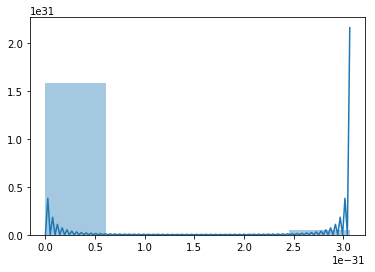

In [42]:
sns.distplot(model.predict([val_x, val_X[:32, :]]))

In [34]:
im = Image.fromarray(np.uint8(x[10, :, :, :]))
im.show()

In [33]:
decode_predictions(predictions)[10]

[('n03188531', 'diaper', 0.37180585),
 ('n02834397', 'bib', 0.24477212),
 ('n04209133', 'shower_cap', 0.09811678),
 ('n02892767', 'brassiere', 0.09649295),
 ('n04370456', 'sweatshirt', 0.05326038)]

In [41]:
model.fit_generator(generator=train_image_generator,
                    validation_data=validation_image_generator,
                    epochs=10)

Epoch 1/10
35/35 [==============================] - 53s 2s/step - loss: 1702.3782 - mean_squared_error: 1702.3782 - val_loss: 16.9756 - val_mean_squared_error: 16.9756
Epoch 2/10
35/35 [==============================] - 16s 446ms/step - loss: 105.8839 - mean_squared_error: 105.8839 - val_loss: 21.1053 - val_mean_squared_error: 21.1053
Epoch 3/10
35/35 [==============================] - 16s 462ms/step - loss: 45.8277 - mean_squared_error: 45.8277 - val_loss: 25.2284 - val_mean_squared_error: 25.2284
Epoch 4/10
35/35 [==============================] - 17s 477ms/step - loss: 35.9876 - mean_squared_error: 35.9876 - val_loss: 6.3319 - val_mean_squared_error: 6.3319
Epoch 5/10
35/35 [==============================] - 17s 477ms/step - loss: 25.3791 - mean_squared_error: 25.3791 - val_loss: 0.8395 - val_mean_squared_error: 0.8395
Epoch 6/10
35/35 [==============================] - 16s 469ms/step - loss: 5.0160 - mean_squared_error: 5.0160 - val_loss: 0.7374 - val_mean_squared_error: 0.7374
Epo

In [50]:
np.sqrt(np.mean(np.power(subsampled_validation_image_df.deal_probability.values - subsampled_validation_image_df.deal_probability.mean(), 2)))

0.0723544687816741

In [101]:
inputs = Input(shape=(1,))
embedding = Embedding(len(category_index_mapping), 1, input_length=1)(inputs)

In [107]:
dense = Dense(64)(Flatten()(embedding))

In [108]:
outputs = Dense(1, activation='sigmoid')(dense)

In [114]:
model = Model(inputs=inputs, outputs=outputs)

In [115]:
model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mean_squared_error'])

In [116]:
model.fit(x=subsampled_train_df.category_index.values, y=subsampled_train_df.deal_probability.values, batch_size=2048,
         validation_data = (subsampled_validation_df.category_index.values, subsampled_validation_df.deal_probability.values), epochs=10)

Train on 120274 samples, validate on 30068 samples
Epoch 1/10
120274/120274 [==============================] - 1s 7us/step - loss: 0.1495 - mean_squared_error: 0.0645 - val_loss: 0.1402 - val_mean_squared_error: 0.0703
Epoch 2/10
120274/120274 [==============================] - 0s 3us/step - loss: 0.1367 - mean_squared_error: 0.0717 - val_loss: 0.1367 - val_mean_squared_error: 0.0740
Epoch 3/10
120274/120274 [==============================] - 0s 3us/step - loss: 0.1346 - mean_squared_error: 0.0737 - val_loss: 0.1352 - val_mean_squared_error: 0.0747
Epoch 4/10
120274/120274 [==============================] - 0s 3us/step - loss: 0.1335 - mean_squared_error: 0.0739 - val_loss: 0.1342 - val_mean_squared_error: 0.0745
Epoch 5/10
120274/120274 [==============================] - 0s 3us/step - loss: 0.1327 - mean_squared_error: 0.0736 - val_loss: 0.1335 - val_mean_squared_error: 0.0743
Epoch 6/10
120274/120274 [==============================] - 0s 3us/step - loss: 0.1322 - mean_squared_error: 